In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [2]:

import os, time, random
import torch
import random
import warnings
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.filterwarnings("ignore", category=UserWarning)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# data_path = "/content/drive/MyDrive/Harvard_Chest_XRay/"
data_path = "drive/My Drive/NIH_Chest_XRay/"
#data_path = "drive/My Drive/Harvard_Chest_XRay/"

sample_ratio = 0.4
batch_size = 80
num_epochs = 10

In [4]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

**DATA PREPROCESSING**

In [5]:
%run "/content/drive/MyDrive/Colab Notebooks/utils.ipynb"
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

**MODEL TRAINING**

In [6]:
def save_metrics(loss, accuracy, model):
  np.save("{}{}_train_loss.npy".format(data_path, model), loss)
  np.save("{}{}_train_accuracy.npy".format(data_path, model), accuracy)

In [ ]:
# Define the AlexNet model and set Pretraining to False to train model from scratch
model = torch.hub.load('pytorch/vision:v0.10.0', 'alexnet', pretrained=False)
model.classifier[6] = nn.Linear(4096, len(dataset.classes))
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)
losses, accuracies, true, pred, v_accuracies, v_losses = [], [], [], [], [], []

# Train model on training set
for epoch in range(num_epochs):
    train_loss, train_accuracy, start_time = 0.0, 0.0, time.time()
    with tqdm(total=len(train_loader), desc=f'Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
      for inputs, labels in train_loader:
          inputs = inputs.to(device)
          labels = labels.to(device)

          optimizer.zero_grad()
          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()
          train_loss += loss.item() * inputs.size(0)
          train_accuracy += torch.sum(preds == labels.data)
          pred.extend(preds.cpu().numpy())
          true.extend(labels.cpu().numpy())
          
          pbar.set_postfix({'loss': loss.item()})
          pbar.update()

    train_loss /= len(train_indices)
    train_accuracy /= len(train_indices)
    _recall = recall_score(true, pred, average='macro')
    _precision = precision_score(true, pred, average='macro')
    _fscore = f1_score(true, pred, average='macro')

    print('Epoch: {} | Accuracy: {:.4f} | Loss: {:.4f} | Recall: {:.4f} | Precision: {:.4f} | F-Score: {:.4f} | Time: {:.4f}s'.format(epoch+1, train_accuracy, train_loss, _recall, _precision, _fscore, time.time() - start_time))
    val_accuracy, val_loss = evaluate_model(model, val_loader, val_indices, 'VALIDATION', criterion, data_path, "AlexNet")
    v_accuracies.append(val_accuracy)
    v_losses.append(val_loss)
    losses.append(train_loss)
    accuracies.append(train_accuracy.item())

save_metrics(losses, accuracies, "AlexNet")

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Epoch 1/10: 100%|██████████| 63/63 [05:53<00:00,  5.61s/batch, loss=2.63]

Epoch: 1 | Accuracy: 0.0913 | Loss: 2.6861 | Recall: 0.0629 | Precision: 0.0528 | F-Score: 0.0330 | Time: 353.3551s


VALIDATION: Accuracy: 0.1130 | Loss: 2.6165 | Recall: 0.0667 | Precision: 0.0075 | F-score: 0.0135



Epoch 2/10: 100%|██████████| 63/63 [01:35<00:00,  1.52s/batch, loss=2.59]


Epoch: 2 | Accuracy: 0.1105 | Loss: 2.6298 | Recall: 0.0648 | Precision: 0.0527 | F-Score: 0.0268 | Time: 95.8657s
VALIDATION: Accuracy: 0.1130 | Loss: 2.6247 | Recall: 0.0667 | Precision: 0.0075 | F-score: 0.0135



Epoch 3/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/batch, loss=2.69]


Epoch: 3 | Accuracy: 0.1101 | Loss: 2.6298 | Recall: 0.0654 | Precision: 0.0527 | F-Score: 0.0238 | Time: 96.3093s
VALIDATION: Accuracy: 0.1130 | Loss: 2.6246 | Recall: 0.0667 | Precision: 0.0075 | F-score: 0.0135



Epoch 4/10: 100%|██████████| 63/63 [01:36<00:00,  1.53s/batch, loss=2.77]


Epoch: 4 | Accuracy: 0.1093 | Loss: 2.6275 | Recall: 0.0656 | Precision: 0.0522 | F-Score: 0.0219 | Time: 96.3006s
VALIDATION: Accuracy: 0.1130 | Loss: 2.5970 | Recall: 0.0667 | Precision: 0.0075 | F-score: 0.0135



Epoch 5/10: 100%|██████████| 63/63 [01:34<00:00,  1.50s/batch, loss=2.65]


Epoch: 5 | Accuracy: 0.1087 | Loss: 2.6128 | Recall: 0.0671 | Precision: 0.0697 | F-Score: 0.0277 | Time: 94.7220s
VALIDATION: Accuracy: 0.1172 | Loss: 2.6032 | Recall: 0.0704 | Precision: 0.0220 | F-score: 0.0197



Epoch 6/10: 100%|██████████| 63/63 [01:35<00:00,  1.52s/batch, loss=2.58]


Epoch: 6 | Accuracy: 0.1145 | Loss: 2.6024 | Recall: 0.0702 | Precision: 0.0749 | F-Score: 0.0356 | Time: 96.0651s
VALIDATION: Accuracy: 0.1116 | Loss: 2.6034 | Recall: 0.0680 | Precision: 0.0321 | F-score: 0.0236



Epoch 7/10: 100%|██████████| 63/63 [01:31<00:00,  1.45s/batch, loss=2.71]


Epoch: 7 | Accuracy: 0.1099 | Loss: 2.6230 | Recall: 0.0715 | Precision: 0.0710 | F-Score: 0.0384 | Time: 91.7657s
VALIDATION: Accuracy: 0.1269 | Loss: 2.5821 | Recall: 0.0882 | Precision: 0.0179 | F-score: 0.0293



Epoch 8/10: 100%|██████████| 63/63 [01:33<00:00,  1.48s/batch, loss=2.52]


Epoch: 8 | Accuracy: 0.1314 | Loss: 2.5945 | Recall: 0.0739 | Precision: 0.0717 | F-Score: 0.0392 | Time: 93.6309s
VALIDATION: Accuracy: 0.1269 | Loss: 2.5617 | Recall: 0.0945 | Precision: 0.0750 | F-score: 0.0384



Epoch 9/10: 100%|██████████| 63/63 [01:34<00:00,  1.50s/batch, loss=2.58]


Epoch: 9 | Accuracy: 0.1310 | Loss: 2.5776 | Recall: 0.0761 | Precision: 0.0727 | F-Score: 0.0401 | Time: 94.4251s
VALIDATION: Accuracy: 0.1255 | Loss: 2.5495 | Recall: 0.0901 | Precision: 0.0237 | F-score: 0.0303



Epoch 10/10: 100%|██████████| 63/63 [01:35<00:00,  1.51s/batch, loss=2.55]


Epoch: 10 | Accuracy: 0.1336 | Loss: 2.5694 | Recall: 0.0784 | Precision: 0.0748 | F-Score: 0.0421 | Time: 95.3634s
VALIDATION: Accuracy: 0.1311 | Loss: 2.5386 | Recall: 0.0928 | Precision: 0.0267 | F-score: 0.0338



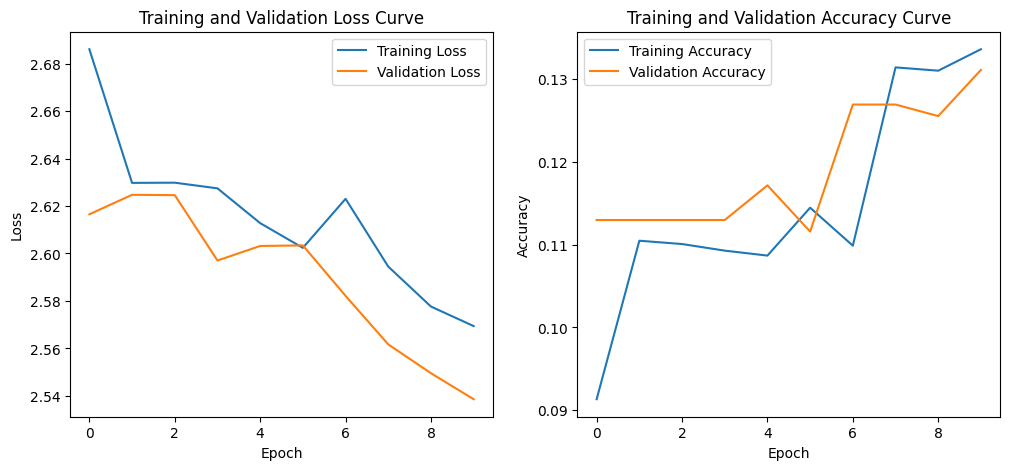

In [ ]:
#Plotting the Loss and Accuracy Curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(losses, label = "Training Loss")
ax1.plot(v_losses, label = "Validation Loss")
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss Curve')
ax1.legend()

ax2.plot(accuracies, label = "Training Accuracy")
ax2.plot(v_accuracies, label = "Validation Accuracy")
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.set_title('Training and Validation Accuracy Curve')
ax2.legend()

plt.show()

In [ ]:
#Evaluate Model on Test Set
evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, "AlexNet")

In [ ]:
torch.save(model.state_dict(), "{}alexnet.pth".format(data_path))

In [ ]:
#Obtain TSNE Plot

features = []
labels = []
for images, targets in train_loader:
    images = images.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        output = model(images)
        features.append(output.cpu().numpy())
        labels.append(targets.cpu().numpy())

features = np.vstack(features)
labels = np.concatenate(labels)

# Perform t-SNE on the feature vectors
tsne = TSNE(n_components=2, perplexity = 25, learning_rate = 600, n_iter = 900)
tsne_features = tsne.fit_transform(features)

tsne_df = pd.DataFrame(data=tsne_features, columns=['t-SNE 1', 't-SNE 2'])
tsne_df['label'] = labels

# Plot the t-SNE plot with seaborn
sns.scatterplot(data=tsne_df, x='t-SNE 1', y='t-SNE 2', hue='label', palette='tab10')
plt.title('t-SNE Plot')
plt.show()

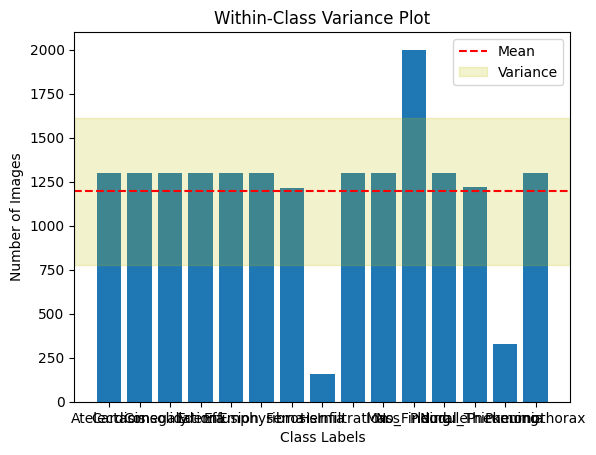

In [22]:

# Get the class labels and the number of classes
class_labels = dataset.classes
num_classes = len(class_labels)

# Get the number of images per class
num_images_per_class = []
for i in range(num_classes):
    class_indices = np.where(np.array(dataset.targets) == i)[0]
    num_images_per_class.append(len(class_indices))

# Compute the mean and variance of the images per class
mean_num_images = np.mean(num_images_per_class)
var_num_images = np.var(num_images_per_class)

# Plot the within-class variance
fig, ax = plt.subplots()
ax.bar(class_labels, num_images_per_class)
ax.axhline(y=mean_num_images, linestyle='--', color='r', label='Mean')
ax.axhspan(mean_num_images - np.sqrt(var_num_images), mean_num_images + np.sqrt(var_num_images),
           alpha=0.2, color='y', label='Variance')
ax.legend()
plt.xticks(rotation = 0)
plt.ylabel('Number of Images')
plt.xlabel('Class Labels')
plt.title('Within-Class Variance Plot')
plt.show()

In [23]:
def within_class_variance(dataset, model):
    # Set the model to evaluation mode
    model.load_state_dict(model['model_state_dict'])
    model.eval()
    # Get the feature vectors and labels for the dataset
    features = []
    labels = []
    for images, targets in train_loader:
        with torch.no_grad():
          images = images.to(device)
          targets = targets.to(device)
          output = model(images)
          features.append(output.cpu().numpy()[0])
          labels.append(targets.cpu().numpy()[0])
    features = np.array(features)
    labels = np.array(labels)
    
    # Calculate the within-class variance for each class
    class_variances = []
    for c in np.unique(labels):
        class_features = features[labels == c]
        class_mean = np.mean(class_features, axis=0)
        class_variance = np.mean(np.sum((class_features - class_mean)**2, axis=1))
        class_variances.append(class_variance)
    
    return class_variances

# Define the dataset and model
# Calculate the within-class variance
class_variances = within_class_variance(dataset, model)

# Plot the within-class variances for each class
plt.bar(np.arange(len(class_variances)), class_variances)
plt.xticks(np.arange(len(class_variances)), dataset.classes, rotation='vertical')
plt.ylabel('Within-class variance')
plt.show()

TypeError: ignored